<a href="https://colab.research.google.com/github/UJ911/Energy-Demand-Forecast/blob/main/Energy_Demand_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Electricity Demand Forecasting Model-Ujjwal Jajoo,BITS Goa**
So in the given problem statement we have been given weather data of different locations, we've also been provided with electricity demand data which covers all these locations, we can use the training data as electricity demand and provided weather data from 1st jan 2021 to 31st dec 2022. Post that we forecast using actual data till previous day. We have mutiple options we can use to forecats this type of time series, we can start by using a very famous  *ARIMA*. This model takes into account the Autoregressive term,i.e, the currently value of electricity demand is very correlated to the previous demands   

---
We use ARIMA(which is a statistical modelling technique) instead of other Machine Learning as the time series has corelation within itself(next hour's energy demand does depend on the demand right now,it'll be quite clear as we do statistical analysis on the data for hyperparameter tuning here)


---


First we check the trend and seasonality in the data, it is quite evident that as it is hourly data thus the seasonality of 24 lags will be observed.




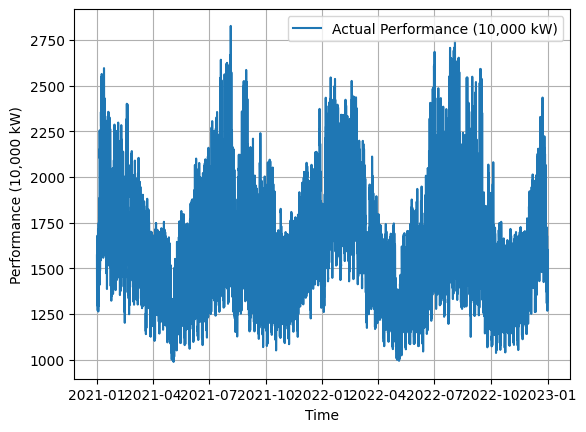

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('demand.csv',nrows=17520)#nrows used because we can only use values till 31st dec 2022 for prediction iitially

# Converting the 'datetime' column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'],format='%d-%m-%Y %H:%M')
df.set_index('datetime', inplace=True)
plt.plot(df['actual_performance(10'], label='Actual Performance (10,000 kW)')
plt.xlabel('Time')
plt.ylabel('Performance (10,000 kW)')
plt.legend()
plt.grid(True)
plt.show()

It is very evident that we have seasonality in the data. For furthur evidence.

In [ ]:


from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

stationarity_test(df['actual_performance(10'])


Results of Dickey-Fuller Test:
Test Statistic                -8.137166e+00
p-value                        1.051633e-12
#Lags Used                     4.300000e+01
Number of Observations Used    1.747600e+04
Critical Value (1%)           -3.430724e+00
Critical Value (5%)           -2.861705e+00
Critical Value (10%)          -2.566858e+00
dtype: float64


As the data is stationary(p value<0.05), we need not difference it.

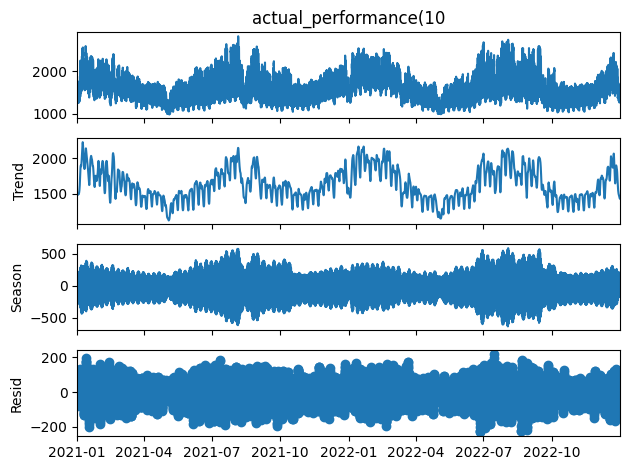

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(df['actual_performance(10'],period=24)
res = stl.fit()
res.plot()
plt.show()

We see there is a very clear trend and seasonality in the data thus we see that it is quite evidently we can use an [SARIMA](https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/) model.

---

Now we need to see what (p,d,q) (P,D,Q,S) values we need to choose so as to perfectly model the data. For this we use the AIC and BIC statistical tests.

In [ ]:

import itertools
import statsmodels.api as sm

# Define the p, d, q, P, D, Q, and s ranges for the SARIMA model
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

best_aic = float('inf')
best_bic = float('inf')
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['actual_performance(10'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            print('SARIMAX{}x{} - BIC:{}'.format(param, param_seasonal, results.bic))

            if results.aic < best_aic:
                best_aic = results.aic
                best_bic = results.bic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print('Best SARIMAX{}x{} - AIC:{} BIC:{}'.format(best_pdq, best_seasonal_pdq, best_aic,best_bic))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(0, 0, 0, 24) - AIC:309537.4561467655
SARIMAX(0, 0, 0)x(0, 0, 0, 24) - BIC:309545.22718805075


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(0, 0, 1, 24) - AIC:286420.4559299119
SARIMAX(0, 0, 0)x(0, 0, 1, 24) - BIC:286435.99527072156


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(0, 1, 0, 24) - AIC:227274.24459201074
SARIMAX(0, 0, 0)x(0, 1, 0, 24) - BIC:227282.01426241556


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(0, 1, 1, 24) - AIC:226961.62492317267
SARIMAX(0, 0, 0)x(0, 1, 1, 24) - BIC:226977.1615184576


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 0, 0, 24) - AIC:227247.035980763
SARIMAX(0, 0, 0)x(1, 0, 0, 24) - BIC:227262.5754358877


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 0, 1, 24) - AIC:227216.84652611671
SARIMAX(0, 0, 0)x(1, 0, 1, 24) - BIC:227240.15553733113


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 1, 0, 24) - AIC:226991.83651493915
SARIMAX(0, 0, 0)x(1, 1, 0, 24) - BIC:227007.37322469623


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 1, 1, 24) - AIC:226466.48970310978
SARIMAX(0, 0, 0)x(1, 1, 1, 24) - BIC:226489.79459603722


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  

SARIMAX(0, 0, 1)x(0, 0, 0, 24) - AIC:285841.31121582235
SARIMAX(0, 0, 1)x(0, 0, 0, 24) - BIC:285856.8531842278
SARIMAX(0, 0, 1)x(0, 0, 1, 24) - AIC:262871.6553055022
SARIMAX(0, 0, 1)x(0, 0, 1, 24) - BIC:262894.96414523415


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(0, 1, 0, 24) - AIC:204838.362875051
SARIMAX(0, 0, 1)x(0, 1, 0, 24) - BIC:204853.90210153896


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(0, 1, 1, 24) - AIC:204557.20507513633
SARIMAX(0, 0, 1)x(0, 1, 1, 24) - BIC:204580.50979634572


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(1, 0, 0, 24) - AIC:204820.85595947647
SARIMAX(0, 0, 1)x(1, 0, 0, 24) - BIC:204844.16514216355


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(1, 0, 1, 24) - AIC:204782.46893970598
SARIMAX(0, 0, 1)x(1, 0, 1, 24) - BIC:204813.5473926819


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(1, 1, 0, 24) - AIC:204595.70242595283
SARIMAX(0, 0, 1)x(1, 1, 0, 24) - BIC:204619.00749058847


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(0, 0, 0, 24) - AIC:202783.45222595945
SARIMAX(0, 1, 0)x(0, 0, 0, 24) - BIC:202791.22321016216


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(0, 0, 1, 24) - AIC:187584.92089884565
SARIMAX(0, 1, 0)x(0, 0, 1, 24) - BIC:187600.4601253336


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(0, 1, 0, 24) - AIC:172255.70776580338
SARIMAX(0, 1, 0)x(0, 1, 0, 24) - BIC:172263.47737904737


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dat

AIC and BIC tests help us so that our model is not overfitting on the data and that we dont make our model very complicated so the lower the values the better the model work, here we see that the best possible fit is (0,1,1)(0,0,2,24). Thus we stick to this model.

Thus now we try fitting the actual data to the SARIMA(1,0,1)(0,0,2,24) model on a smaller scale to try understanding how nicely it fits.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


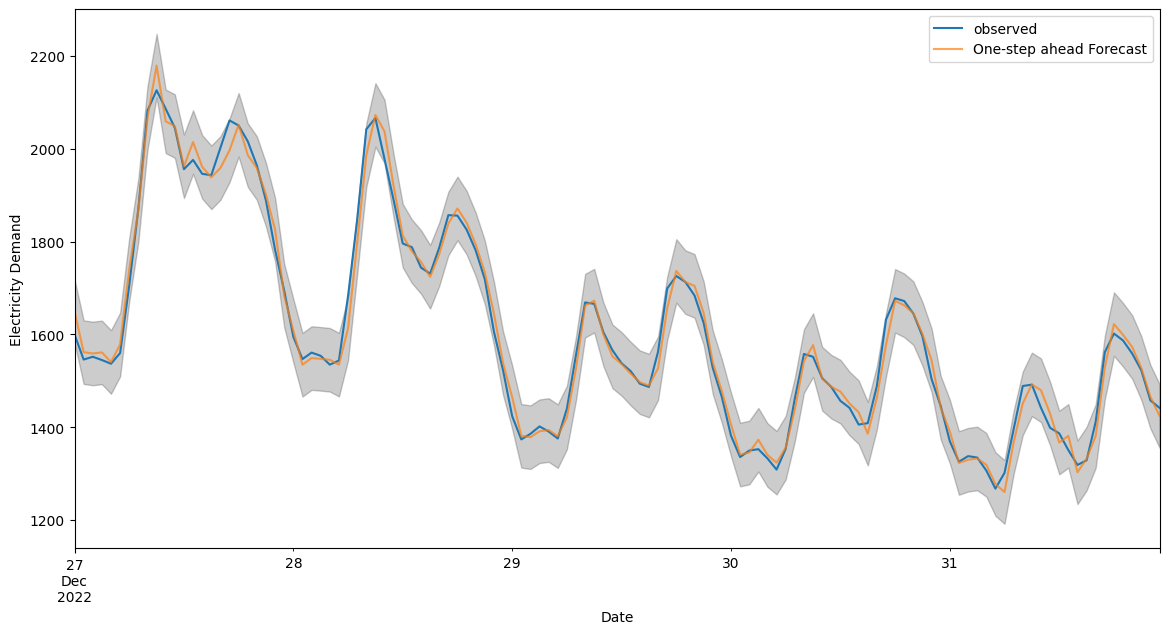

In [ ]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df['actual_performance(10'],
                                order=(1,0,1),
                                seasonal_order=(0, 0, 2, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
pred = results.get_prediction(start=pd.to_datetime('2022-12-27 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2022-12-27':]['actual_performance(10'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Demand')
plt.legend()
plt.show()


In [ ]:
data = df['actual_performance(10']
model = sm.tsa.statespace.SARIMAX(data, order=(1,0, 1), seasonal_order=(0, 0, 2, 24))
results = model.fit()
results.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                   actual_performance(10   No. Observations:                17520
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 24)   Log Likelihood              -87118.947
Date:                                 Thu, 20 Feb 2025   AIC                         174245.895
Time:                                         11:28:40   BIC                         174276.979
Sample:                                     01-01-2021   HQIC                        174256.130
                                          - 12-31-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5612      0.004    136.217      0.000       0.553       0.569
ma.S.L24       0.9573      0.005    182.519      0.000       0.947       0.968
ma.S.L48       0.5391      0.005    103.664      0.000       0.529       0.549
sigma2      1219.4197      8.089    150.745      0.000    1203.565    1235.274
===================================================================================
Ljung-Box (L1) (Q):                 457.16   Jarque-Bera (JB):              9407.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.80
Prob(H) (two-sided):                  0.24   Kurtosis:                         6.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ljung box test prob suggest that the residues are non stationary, which means we have failed to capture some sort of trend in the time series. Thus now we take help of the SARIMAX model which adds Exogenous Regressors to this model(in our case the weather data).


---

For our ease, we've merged all the data tables(excluding wind direction), now we try to find which of these factors cause causality(past values of weather data influence electricity demand) using [Granger Causality Tests](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/granger-causality-test#:~:text=The%20Granger%20causality%20test%20is%20an%20economic%20analysis%20method%20used,sequence%20of%20the%20same%20order.).

---

After this we store the relevant factors and display in the next window.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Load dataset
file_path = "merged_weather_demand_data.csv"
data = pd.read_csv(file_path)

# Ensure all variables are numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Define target variable (dependent variable)
y = data['actual_performance(10'].diff()  # Ensure 'y' is correctly defined

# Select potential exogenous variables
exogenous_candidates = data.columns.drop('actual_performance(10')
from statsmodels.tsa.stattools import grangercausalitytests

# Maximum number of lags to test
max_lag = 3  # Adjust based on domain knowledge

# Dictionary to store p-values
granger_results = {}

for col in exogenous_candidates:
    print(f"\nTesting causality between 'y' and '{col}'...")

    try:
        # Create a test dataset with 'y' and the current column
        test_data = pd.concat([y, data[col].diff()], axis=1).dropna()

        # Adjust max_lag if data is too small
        adjusted_max_lag = min(max_lag, len(test_data) - 1)

        if adjusted_max_lag <= 0:
            print(f"Skipping {col}: Not enough data for lag testing.")
            continue

        # Run the Granger test
        test_result = grangercausalitytests(test_data, maxlag=adjusted_max_lag, verbose=False)

        # Extract p-values for each lag
        p_values = [round(test_result[lag][0]['ssr_chi2test'][1], 4) for lag in range(1, adjusted_max_lag + 1)]
        granger_results[col] = p_values

        print(f"P-values for {col}: {p_values}")

    except Exception as e:
        print(f"Error testing column {col}: {e}")
# Select variables with at least one significant lag (p-value ≤ 0.05)
significant_exogenous = [col for col, p_vals in granger_results.items() if any(p <= 0.05 for p in p_vals)]

print("Selected Exogenous Variables:", significant_exogenous)




Testing causality between 'y' and 'datetime'...
Skipping datetime: Not enough data for lag testing.

Testing causality between 'y' and 'precipitation_hikone'...
P-values for precipitation_hikone: [0.3433, 0.4614, 0.5095]

Testing causality between 'y' and 'temperature_hikone'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for temperature_hikone: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'dew_point_temperature_hikone'...
P-values for dew_point_temperature_hikone: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'humidity_hikone'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for humidity_hikone: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'wind_speed_hikone'...
P-values for wind_speed_hikone: [0.0001, 0.0, 0.0]

Testing causality between 'y' and 'snowfall_hikone'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for snowfall_hikone: [0.8598, 0.8975, 0.9537]

Testing causality between 'y' and 'precipitation_kobe'...
P-values for precipitation_kobe: [0.9585, 0.1599, 0.1282]

Testing causality between 'y' and 'temperature_kobe'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for temperature_kobe: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'dew_point_temperature_kobe'...
P-values for dew_point_temperature_kobe: [0.0416, 0.1734, 0.0066]

Testing causality between 'y' and 'humidity_kobe'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for humidity_kobe: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'wind_speed_kobe'...
P-values for wind_speed_kobe: [0.1692, 0.0026, 0.0]

Testing causality between 'y' and 'snowfall_kobe'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for snowfall_kobe: [0.8836, 0.9376, 0.6136]

Testing causality between 'y' and 'precipitation_kyoto'...
P-values for precipitation_kyoto: [0.0979, 0.1392, 0.3024]

Testing causality between 'y' and 'temperature_kyoto'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for temperature_kyoto: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'dew_point_temperature_kyoto'...
P-values for dew_point_temperature_kyoto: [0.6173, 0.085, 0.0]

Testing causality between 'y' and 'humidity_kyoto'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for humidity_kyoto: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'wind_speed_kyoto'...
P-values for wind_speed_kyoto: [0.691, 0.0148, 0.0]

Testing causality between 'y' and 'snowfall_kyoto'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for snowfall_kyoto: [0.466, 0.8283, 0.9442]

Testing causality between 'y' and 'precipitation_osaka'...
P-values for precipitation_osaka: [0.0781, 0.2697, 0.2521]

Testing causality between 'y' and 'temperature_osaka'...
P-values for temperature_osaka: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'dew_point_temperature_osaka'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for dew_point_temperature_osaka: [0.1824, 0.0072, 0.0]

Testing causality between 'y' and 'humidity_osaka'...
P-values for humidity_osaka: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'wind_speed_osaka'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for wind_speed_osaka: [0.3798, 0.0, 0.0]

Testing causality between 'y' and 'snowfall_osaka'...
Error testing column snowfall_osaka: The x values include a column with constant values and so the test statistic cannot be computed.

Testing causality between 'y' and 'precipitation_shionomisaki'...
P-values for precipitation_shionomisaki: [0.2046, 0.1552, 0.1576]

Testing causality between 'y' and 'temperature_shionomisaki'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for temperature_shionomisaki: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'dew_point_temperature_shionomisaki'...
P-values for dew_point_temperature_shionomisaki: [0.0274, 0.0109, 0.0031]

Testing causality between 'y' and 'humidity_shionomisaki'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for humidity_shionomisaki: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'wind_speed_shionomisaki'...
P-values for wind_speed_shionomisaki: [0.9496, 0.4885, 0.0]

Testing causality between 'y' and 'snowfall_shionomisaki'...
Error testing column snowfall_shionomisaki: The x values include a column with constant values and so the test statistic cannot be computed.

Testing causality between 'y' and 'precipitation_toyooka'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for precipitation_toyooka: [0.1686, 0.5449, 0.5378]

Testing causality between 'y' and 'temperature_toyooka'...
P-values for temperature_toyooka: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'dew_point_temperature_toyooka'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for dew_point_temperature_toyooka: [0.3748, 0.0004, 0.0]

Testing causality between 'y' and 'humidity_toyooka'...
P-values for humidity_toyooka: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'wind_speed_toyooka'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for wind_speed_toyooka: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'snowfall_toyooka'...
P-values for snowfall_toyooka: [0.5065, 0.7077, 0.7532]

Testing causality between 'y' and 'precipitation_wakayama'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for precipitation_wakayama: [0.5939, 0.555, 0.5952]

Testing causality between 'y' and 'temperature_wakayama'...
P-values for temperature_wakayama: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'dew_point_temperature_wakayama'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for dew_point_temperature_wakayama: [0.7253, 0.0, 0.0]

Testing causality between 'y' and 'humidity_wakayama'...
P-values for humidity_wakayama: [0.0, 0.0, 0.0]

Testing causality between 'y' and 'wind_speed_wakayama'...
P-values for wind_speed_wakayama: [0.0142, 0.0337, 0.0]

Testing causality between 'y' and 'snowfall_wakayama'...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


P-values for snowfall_wakayama: [0.6108, 0.4653, 0.6315]

Testing causality between 'y' and 'residue'...
Skipping residue: Not enough data for lag testing.
Selected Exogenous Variables: ['temperature_hikone', 'dew_point_temperature_hikone', 'humidity_hikone', 'wind_speed_hikone', 'temperature_kobe', 'dew_point_temperature_kobe', 'humidity_kobe', 'wind_speed_kobe', 'temperature_kyoto', 'dew_point_temperature_kyoto', 'humidity_kyoto', 'wind_speed_kyoto', 'temperature_osaka', 'dew_point_temperature_osaka', 'humidity_osaka', 'wind_speed_osaka', 'temperature_shionomisaki', 'dew_point_temperature_shionomisaki', 'humidity_shionomisaki', 'wind_speed_shionomisaki', 'temperature_toyooka', 'dew_point_temperature_toyooka', 'humidity_toyooka', 'wind_speed_toyooka', 'temperature_wakayama', 'dew_point_temperature_wakayama', 'humidity_wakayama', 'wind_speed_wakayama']


Now we have all thhe factors which contribute to 'y'(actual_demand) causally stored in selected exogenous variables. The issue is that having 28 exogenous variables makes our sarima model extremely complicated and computationally expensive.

---

Thus we try to do feature engineering here, eliminating features which are quite redundant/or keep one feature which is extremely correlated to other ones(p-values<0.05). To check coorelation between the features, we use a heatmap and then we manually eliminate features from the grid.

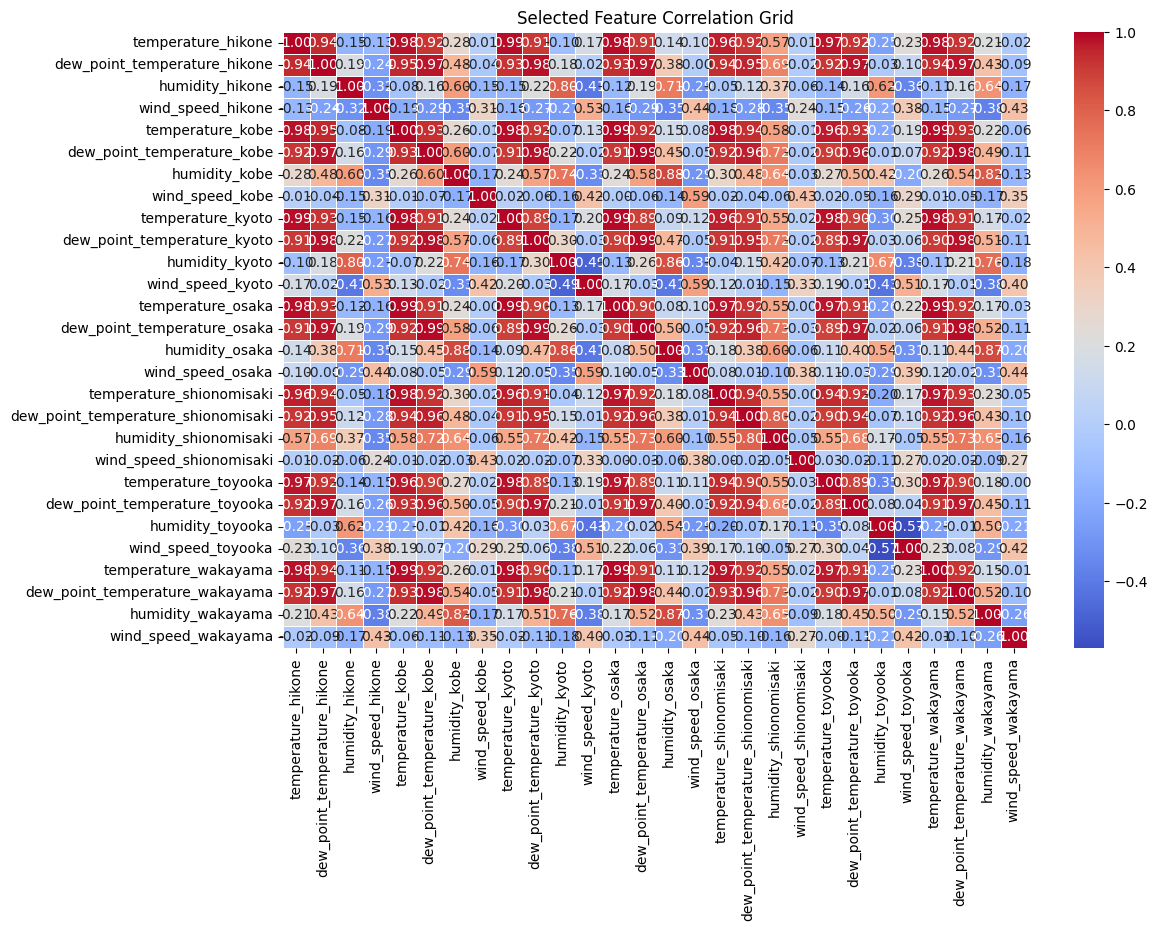

In [ ]:
import seaborn as sns
selected_columns = significant_exogenous
# Filter dataset to include only selected columns
filtered_data = data[selected_columns]

# Compute correlation matrix
correlation_matrix = filtered_data.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Selected Feature Correlation Grid")
plt.show()

# Save correlation matrix as CSV for reference
correlation_matrix.to_csv("selected_correlation_matrix.csv")


So in the above graph we see that all temperature values are quite strongly correlated thus we can eliminate but one value from the temperature and dew point temperature values.
We find manually the factors with highest correlation with the other factors is dew_point_temperature_hikone and temperature_osaka. Apart from that humidity values are also quite strongly correlated and humidity_osaka having the highest average mutual correlation here thus we choose these 3 values as our Exogenous Regressor variables.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

data = pd.read_csv('merged_weather_demand_data.csv')
y = data['actual_performance(10']

selected = ['dew_point_temperature_hikone','humidity_osaka']
X = data[selected]

# Fit SARIMAX Model
model = SARIMAX(y, exog=X, order=(1,0,1), seasonal_order=(0,0,2,24))
results = model.fit()

# Print summary
print(results.summary())

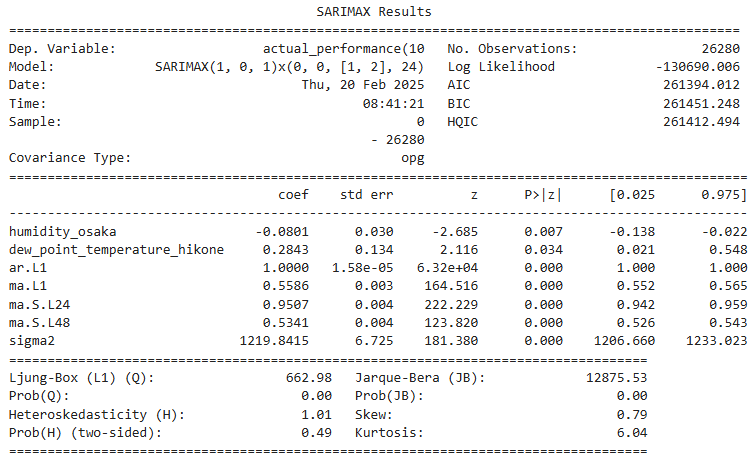

Here we see the process residue exhibits non-stationarity(p-value<0.05) meaning there is very high correlation between residue values, which means we have failed to capture some trend.

---
To factor that in we increase an difference(d) term by 1 to make the series more stationary and check on different parameters


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = data['actual_performance(10']
selected = ['humidity_osaka','dew_point_temperature_hikone']
X = data[selected]

# Fit SARIMAX Model
model = SARIMAX(y, exog=X, order=(1,1,1), seasonal_order=(0,0,2,24))
results = model.fit()

# Print summary
print(results.summary())

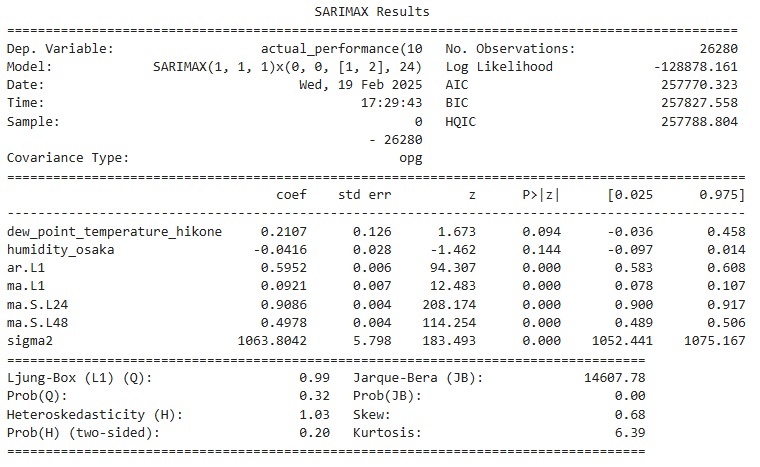

In the above model, we see that the correlation between humidity_osaka and demand is not strong, thus we try to change dew_point_temperature to temperature_osaka and see how that pans out.

In [ ]:

# Define exogenous data (ensure alignment with y)
y = data['actual_performance(10']
selected = ['temperature_osaka','humidity_osaka']
X = data[selected]

# Fit SARIMAX Model
model = SARIMAX(y, exog=X, order=(1,1,1), seasonal_order=(0,0,2,24))
results = model.fit()

# Print summary
print(results.summary())

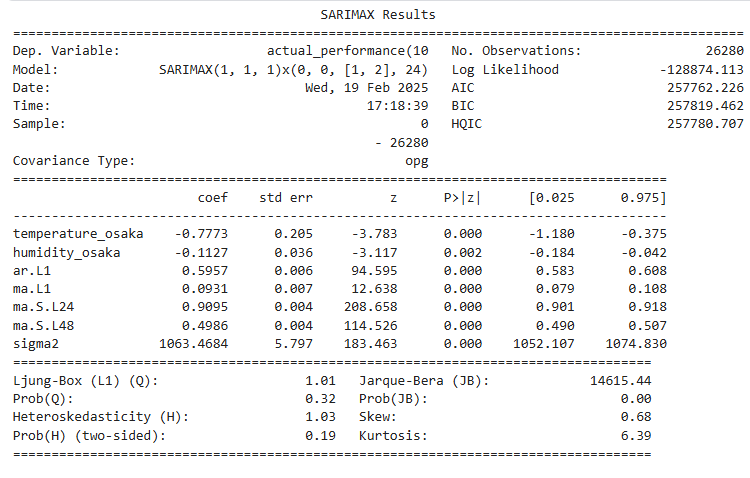

Key Parameters:


*   Exogenous Variables:


1.   
temperature_osaka: Coefficient = -0.7773, p-value = <0.05
Indicates that temperature in Osaka has a significant negative effect on the dependent variable.
2.   humidity_osaka: Coefficient = -0.1127, p-value = <0.05
Indicates that humidity in Osaka also has a significant negative effect.








*   AR and MA Terms:

1.   ar.L1: Coefficient = 0.5957, p-value = <0.05
The first-order autoregressive term is significant and positively contributes to the model.

2.   ma.L1: Coefficient = -0.6905, p-value = <0.05
The first-order moving average term is significant and negatively contributes.

*  Seasonal MA Terms:

1.   ma.S.L24: Coefficient = 0.9095, p-value = <0.05
The seasonal moving average term at lag 24 is significant and positively contributes.

2.   ma.S.L48: Coefficient = 0.4908, p-value = <0.05
The seasonal moving average term at lag 48 is significant and positively contributes.

Sigma2 (Variance of Residuals):

Coefficient = 1063.4684, p-value = <0.05
Indicates the variance of the residuals (unexplained variance).

Model Diagnostics
These statistics help assess the validity of the model:

Ljung-Box (Q):

Test statistic = 1.01, Prob(Q) = 0.32
This tests whether residuals are uncorrelated (white noise). A high p-value (>0.05) indicates that residuals are not significantly autocorrelated.

Heteroskedasticity (H):

Test statistic = 1.03, Prob(H) = 0.19
Tests for constant variance in residuals (homoscedasticity). A high p-value (>0.05) suggests no significant heteroskedasticity.

Jarque-Bera (JB):

Test statistic = 14615.44, Prob(JB) = <0.05
Tests whether residuals are normally distributed. A low p-value (<0.05) suggests residuals deviate from normality.

Skewness: -0.08
Indicates slight asymmetry in residuals' distribution.

Kurtosis: 6.39
Indicates heavy tails in residuals' distribution compared to a normal distribution.

Key Takeaways
Both exogenous variables (temperature_osaka and humidity_osaka) significantly impact the dependent variable.

The AR(1), MA(1), and seasonal MA terms are all significant contributors to modeling the time series.

Residual diagnostics suggest no autocorrelation or heteroskedasticity in residuals, but there is evidence of non-normality.

The model seems to fit well based on its log-likelihood and information criteria values

We see that this is the best performing model when considering AIC, BIC and variable inclusivity, thus this is the model we go with!!

Thus now we can do the actual forecasting.

In [ ]:
#data = data.fillna(method='ffill')
data = data.asfreq('H')
# Split the data into training and testing sets
train_data = data.loc['01-01-2021 00:00:00':'31-12-2022 23:00']
test_data = data.loc['01-01-2023 00:00':]

# Separate dependent variable (y) and exogenous variables (X)
y_train = train_data['actual_performance(10']
X_train = train_data[['humidity_osaka', 'temperature_osaka']]
y_test = test_data['actual_performance(10']
X_test = test_data[['humidity_osaka', 'temperature_osaka']]

# Train the SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(0, 0, 2, 24))
model_fit = model.fit(disp=False)

# Forecast using previous actual values
forecasted_values = []
actual_values = []
history_y = y_train.copy()
history_X = X_train.copy()

for i in range(len(X_test)):
    # Forecast the next value
    forecast = model_fit.get_forecast(steps=1, exog=X_test.iloc[[i]])
    forecasted_values.append(forecast.predicted_mean.iloc[0])

    # Append actual value for plotting
    actual_values.append(y_test.iloc[i])

    # Update history with actual value for future forecasting
    history_y = pd.concat([history_y, pd.Series([y_test.iloc[i]], index=[y_test.index[i]])])
    history_X = pd.concat([history_X, X_test.iloc[[i]]])

# Plotting the results
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, actual_values, label='Actual Data (Testing)', color='green')
plt.plot(y_test.index, forecasted_values, label='Forecasted Data', color='red', linestyle='--')
plt.axvline(x='2023-01-01 00:00:00', color='black', linestyle='--', label='Forecast Start')
plt.legend()
plt.title('SARIMAX Forecast vs Actual Data')
plt.xlabel('Timestamp')
plt.ylabel('Actual Performance (10)')
plt.grid()
plt.show()

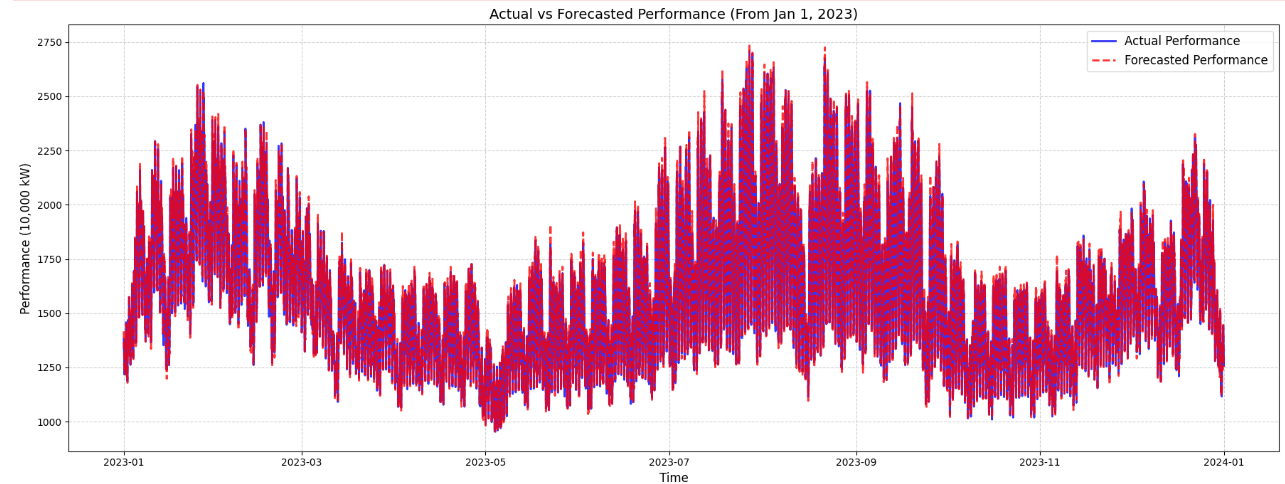

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print("MSE Loss:", mse)

image.png

The MSE loss over the forecasting period is quite low, but we have reassurance that the data is not overfitting because our residuals are not correlated.

# **Ways to improve on the given model**

*   The model is not a very complicated model as fduring feature reduction we kept only 2 features, if we consider other factors as well, then the model can reach better accuracy and forecast in a better way.
*   We can use very intricate machine learning time series analysis models such as LSTM, Transfor architecture, but given such predictable data which does not require extremely high accuracy, I personally don't see the need of using such computationally expensive datasets
*  Regressors such as XGBoost can be used for residue analysis here as the model is not strong against events which might cause unexplainable statistical volitility(i.e unexplainable spikes/downs in values) due to real world events.



---
# **Expected Benefits of Model Deployment**


*   Very computationally efficient compared to various machine and deep models, which is a major factor here as the data needs to be predicted every hour.
*   Explainability- This model takes weights and biases which can be interpretted and explained by humans as they are very simple, thus twerks can be made based on case studies on the model itself to modify it.




